<a href="https://colab.research.google.com/github/dcode05/eva-assignment12/blob/main/EVA_spatial_transformer_CIFAR%2BMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Spatial Transformer Networks Tutorial
=====================================
**Author**: `Ghassen HAMROUNI <https://github.com/GHamrouni>`_

.. figure:: /_static/img/stn/FSeq.png

In this tutorial, you will learn how to augment your network using
a visual attention mechanism called spatial transformer
networks. You can read more about the spatial transformer
networks in the `DeepMind paper <https://arxiv.org/abs/1506.02025>`__

Spatial transformer networks are a generalization of differentiable
attention to any spatial transformation. Spatial transformer networks
(STN for short) allow a neural network to learn how to perform spatial
transformations on the input image in order to enhance the geometric
invariance of the model.
For example, it can crop a region of interest, scale and correct
the orientation of an image. It can be a useful mechanism because CNNs
are not invariant to rotation and scale and more general affine
transformations.

One of the best things about STN is the ability to simply plug it into
any existing CNN with very little modification.



In [1]:
%matplotlib inline

In [2]:
# License: BSD
# Author: Ghassen Hamrouni

from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()   # interactive mode

Loading the data
----------------

In this post we experiment with the classic MNIST dataset. Using a
standard convolutional network augmented with a spatial transformer
network.



In [3]:
''' ---------- FOR MNIST DATASET--------------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)
'''    

' ---------- FOR MNIST DATASET--------------------------------------\n\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\n\n# Training dataset\ntrain_loader = torch.utils.data.DataLoader(\n    datasets.MNIST(root=\'.\', train=True, download=True,\n                   transform=transforms.Compose([\n                       transforms.ToTensor(),\n                       transforms.Normalize((0.1307,), (0.3081,))\n                   ])), batch_size=64, shuffle=True, num_workers=4)\n# Test dataset\ntest_loader = torch.utils.data.DataLoader(\n    datasets.MNIST(root=\'.\', train=False, transform=transforms.Compose([\n        transforms.ToTensor(),\n        transforms.Normalize((0.1307,), (0.3081,))\n    ])), batch_size=64, shuffle=True, num_workers=4)\n'

In [4]:
'''-------------------- FOR CIFAR DATASET------------------------------------'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.4914, 0.4822, 0.4465),  (0.2023, 0.1994, 0.2010))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),  (0.2023, 0.1994, 0.2010))
    ])), batch_size=64, shuffle=True, num_workers=4)


Extracting ./cifar-10-python.tar.gz to .


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Depicting spatial transformer networks
--------------------------------------

Spatial transformer networks boils down to three main components :

-  The localization network is a regular CNN which regresses the
   transformation parameters. The transformation is never learned
   explicitly from this dataset, instead the network learns automatically
   the spatial transformations that enhances the global accuracy.
-  The grid generator generates a grid of coordinates in the input
   image corresponding to each pixel from the output image.
-  The sampler uses the parameters of the transformation and applies
   it to the input image.

.. figure:: /_static/img/stn/stn-arch.png

.. Note::
   We need the latest version of PyTorch that contains
   affine_grid and grid_sample modules.




In [5]:
''' -------------------------------------  COVNET, SPATIAL TRANSFORM MODEL FOR MNIST------------
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net().to(device)
'''

' -------------------------------------  COVNET, SPATIAL TRANSFORM MODEL FOR MNIST------------\nclass Net(nn.Module):\n    def __init__(self):\n        super(Net, self).__init__()\n        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)\n        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)\n        self.conv2_drop = nn.Dropout2d()\n        self.fc1 = nn.Linear(320, 50)\n        self.fc2 = nn.Linear(50, 10)\n\n        # Spatial transformer localization-network\n        self.localization = nn.Sequential(\n            nn.Conv2d(1, 8, kernel_size=7),\n            nn.MaxPool2d(2, stride=2),\n            nn.ReLU(True),\n            nn.Conv2d(8, 10, kernel_size=5),\n            nn.MaxPool2d(2, stride=2),\n            nn.ReLU(True)\n        )\n\n        # Regressor for the 3 * 2 affine matrix\n        self.fc_loc = nn.Sequential(\n            nn.Linear(10 * 3 * 3, 32),\n            nn.ReLU(True),\n            nn.Linear(32, 3 * 2)\n        )\n\n        # Initialize the weights/bias with identity 

In [6]:
''' -------------------------------------  COVNET, SPATIAL TRANSFORM MODEL FOR CIFAR 10-------------'''

class NET(nn.Module):
    def __init__(self):
        super(NET, self).__init__()
        # simple convnet classifier
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

        # spatial transformer localization network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # tranformation regressor for theta
        self.fc_loc = nn.Sequential(
            nn.Linear(128*4*4, 256),
            nn.ReLU(True),
            nn.Linear(256, 3 * 2)
        )

        # initializing the weights and biases with identity transformations
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], 
                                                    dtype=torch.float))

    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, xs.size(1)*xs.size(2)*xs.size(3))

        # calculate the transformation parameters theta
        theta = self.fc_loc(xs)
        # resize theta
        theta = theta.view(-1, 2, 3) 
        # grid generator => transformation on parameters theta
        grid = F.affine_grid(theta, x.size())
        # grid sampling => applying the spatial transformations
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)
        
        # forward pass through the classifier 
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model = NET().to(device)        

Training the model
------------------

Now, let's use the SGD algorithm to train the model. The network is
learning the classification task in a supervised way. In the same time
the model is learning STN automatically in an end-to-end fashion.



In [7]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# A simple test procedure to measure STN the performances on MNIST.
#


def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

Visualizing the STN results
---------------------------

Now, we will inspect the results of our learned visual attention
mechanism.

We define a small helper function in order to visualize the
transformations while training.



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4044: UserWarning: Default grid_sample and affine_grid behavior has changed to

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.316813
Train Epoch: 1 [32000/50000 (64%)]	Loss: 2.251930


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 2.1139, Accuracy: 2442/10000 (24%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.026851
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.780063

Test set: Average loss: 1.7272, Accuracy: 3664/10000 (37%)

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.916153
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.682782

Test set: Average loss: 1.5796, Accuracy: 4235/10000 (42%)

Train Epoch: 4 [0/50000 (0%)]	Loss: 1.412583
Train Epoch: 4 [32000/50000 (64%)]	Loss: 1.765543

Test set: Average loss: 1.6028, Accuracy: 4254/10000 (43%)

Train Epoch: 5 [0/50000 (0%)]	Loss: 1.547304
Train Epoch: 5 [32000/50000 (64%)]	Loss: 1.241885

Test set: Average loss: 1.4563, Accuracy: 4694/10000 (47%)

Train Epoch: 6 [0/50000 (0%)]	Loss: 1.631394
Train Epoch: 6 [32000/50000 (64%)]	Loss: 1.479071

Test set: Average loss: 1.5497, Accuracy: 4467/10000 (45%)

Train Epoch: 7 [0/50000 (0%)]	Loss: 1.402324
Train Epoch: 7 [32000/50000 (64%)]	Loss: 1.268466

Test set: Average loss: 1.4183, Accuracy: 4999/10000 (50%)

Tra

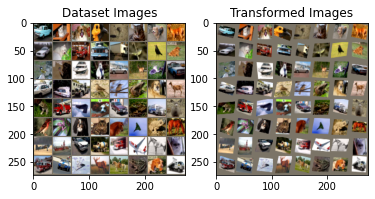

In [8]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 50 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()